In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras 
from keras.layers import Input, Dense, Dropout, LSTM, ConvLSTM1D
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib



In [2]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [3]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction,title="Graph"):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

In [4]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [5]:
df = pd.read_csv("../../data/data_processed_cleaned.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.05
df['mve'] = df['mve'] * 0.1
df['wpg'] = df['wpg'] * 0.1

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 


df_test = pd.read_csv("../../data/data_processed_cleaned_fake.csv")
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y/%m/%d %H:%M')

In [6]:
features_considered = [
                    'price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
### Train dataset 
features = df[features_considered]
features.index = df['date']

scaler_prod = StandardScaler()
scaler_2 = MinMaxScaler()

prod_dataset = scaler_prod.fit_transform(df['production_usage'].values.reshape(-1,1))
prod_dataset = scaler_2.fit_transform(prod_dataset)

scaler_cons = StandardScaler()
scaler_2 = MinMaxScaler()
cons_dataset = scaler_cons.fit_transform(df['consumption_usage'].values.reshape(-1,1))
cons_dataset = scaler_2.fit_transform(cons_dataset)

scaler_all = StandardScaler()
scaler_2 = MinMaxScaler()
dataset = scaler_all.fit_transform(features.values)
dataset = scaler_2.fit_transform(features.values)

### Test dataset
features = df_test[features_considered]
features.index = df_test['date']

scaler_2 = MinMaxScaler()
scaler_prod = StandardScaler()
prod_dataset_test = scaler_prod.fit_transform(df_test['production_usage'].values.reshape(-1,1))
prod_dataset_test = scaler_2.fit_transform(prod_dataset_test)

scaler_2 = MinMaxScaler()
scaler_cons = StandardScaler()
cons_dataset_test = scaler_cons.fit_transform(df_test['consumption_usage'].values.reshape(-1,1))
cons_dataset_test = scaler_2.fit_transform(cons_dataset_test)

scaler_2 = MinMaxScaler()
dataset_test = scaler_all.fit_transform(features.values)
dataset_test = scaler_2.fit_transform(features.values)

In [19]:
print("X -> ",np.min(dataset), np.max(dataset), np.mean(dataset))
print("Y_production ->",np.min(prod_dataset), np.max(prod_dataset), np.mean(prod_dataset))
print("Y_consumption -> ",np.min(cons_dataset), np.max(cons_dataset), np.mean(cons_dataset))

X ->  0.0 1.0 0.39343083597275674
Y_production -> 0.0 1.0 0.31332284305813346
Y_consumption ->  0.0 1.0 0.2666621031566539


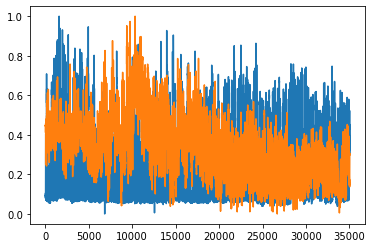

In [23]:
plt.plot(cons_dataset)
plt.plot(prod_dataset)

In [7]:
past_history = 96
future_target = 4
STEP = 1




x, y1 = multivariate_data(dataset, prod_dataset, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x, y2 = multivariate_data(dataset, cons_dataset, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val , y1_val = multivariate_data(dataset_test, prod_dataset_test,
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
x_val , y2_val = multivariate_data(dataset_test, cons_dataset_test,
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [8]:

inputs = Input(shape=(past_history,len(features_considered)))
conv1 = Conv1D(16, kernel_size=4, activation='relu')(inputs)
m = Dropout(0.2)(pool1)
pool1 = MaxPooling1D(pool_size=2)(conv1)
m = LSTM(256,  return_sequences=False)(m)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=1,steps_per_epoch=100)

100/100 [==============================] - 4s 33ms/step - loss: 0.0455 - dense_loss: 0.0245 - dense_1_loss: 0.0210


<ipython-input-9-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.25559267]
 [0.2554874 ]
 [0.2556307 ]
 [0.25602477]]


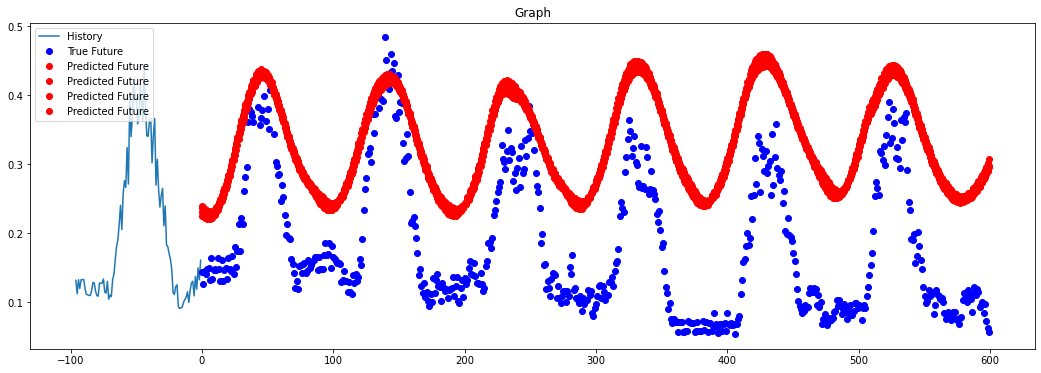

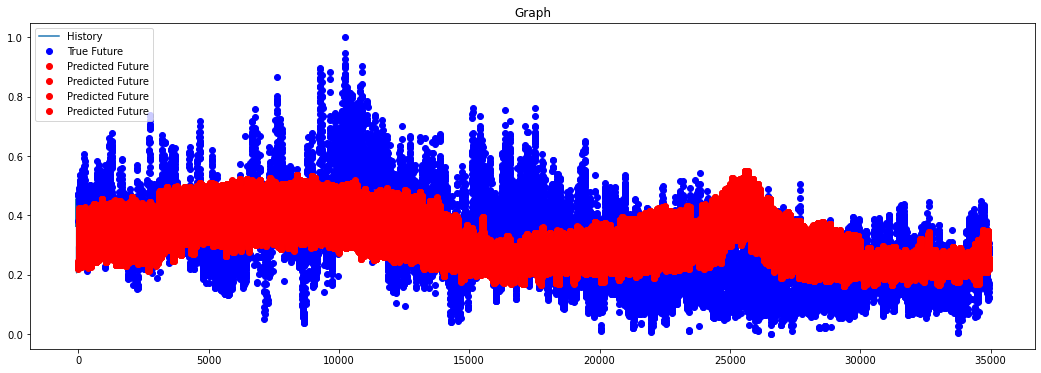

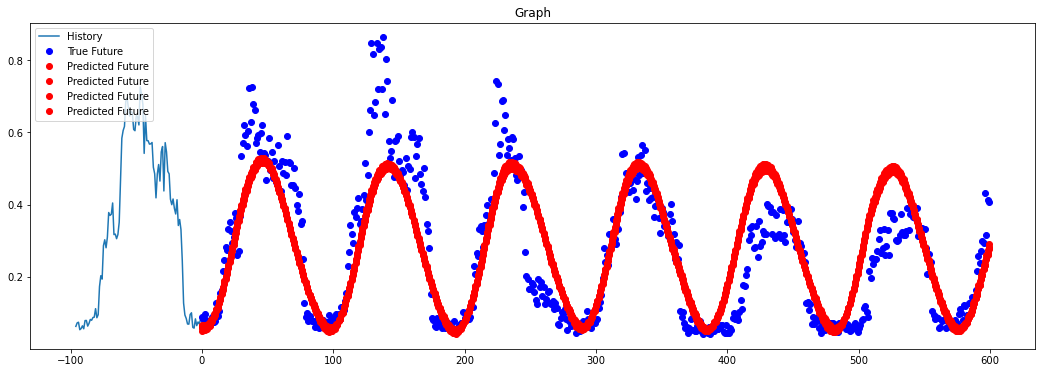

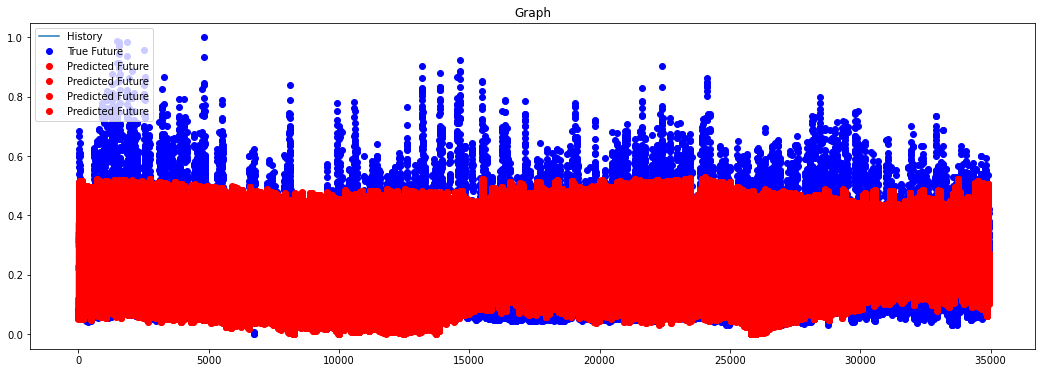

In [9]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])

In [10]:
inputs = Input(shape=(past_history,len(features_considered)))
m = LSTM(64,  return_sequences=False)(inputs)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=10,steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 4s 31ms/step - loss: 0.0585 - dense_2_loss: 0.0285 - dense_3_loss: 0.0300
Epoch 2/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0377 - dense_2_loss: 0.0201 - dense_3_loss: 0.0175
Epoch 3/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0336 - dense_2_loss: 0.0188 - dense_3_loss: 0.0149
Epoch 4/10
100/100 [==============================] - 3s 30ms/step - loss: 0.0326 - dense_2_loss: 0.0182 - dense_3_loss: 0.0144
Epoch 5/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0311 - dense_2_loss: 0.0174 - dense_3_loss: 0.0137
Epoch 6/10
100/100 [==============================] - 3s 29ms/step - loss: 0.0296 - dense_2_loss: 0.0161 - dense_3_loss: 0.0135
Epoch 7/10
100/100 [==============================] - 3s 30ms/step - loss: 0.0293 - dense_2_loss: 0.0160 - dense_3_loss: 0.0134
Epoch 8/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0297 - dense_2_loss: 0.0158

<ipython-input-11-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.31931076]
 [0.31645945]
 [0.31393524]
 [0.31177799]]


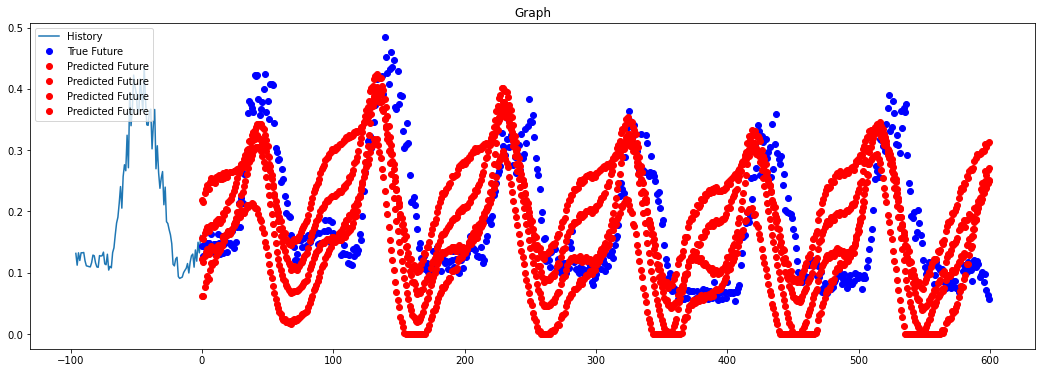

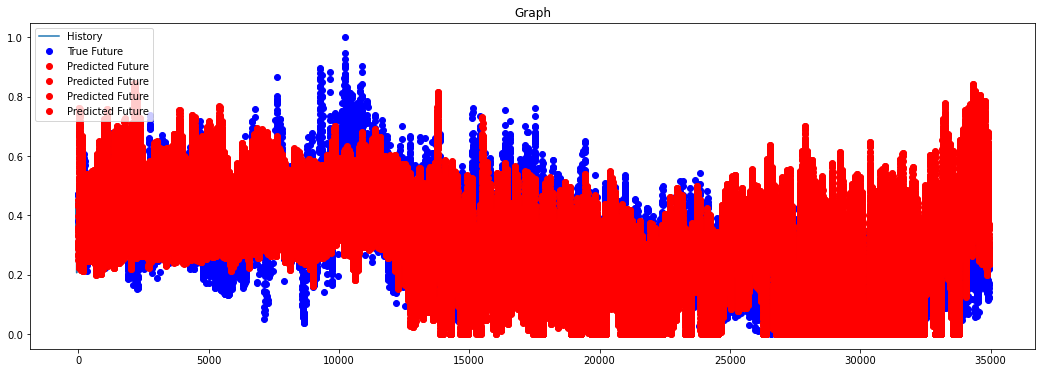

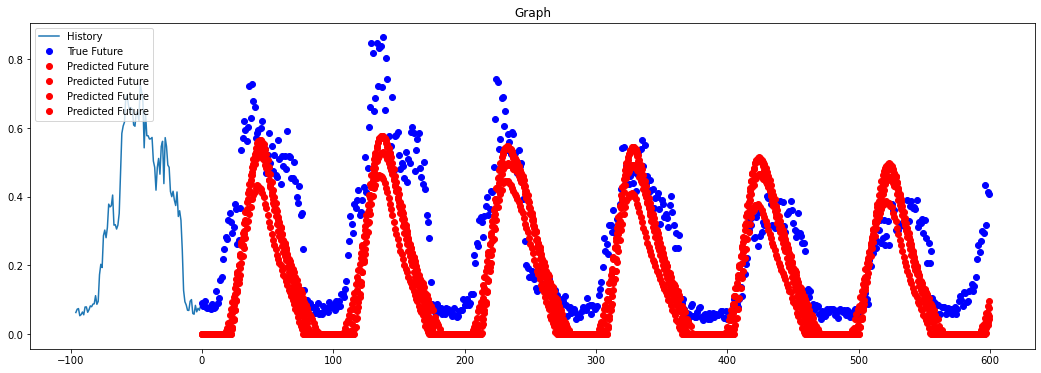

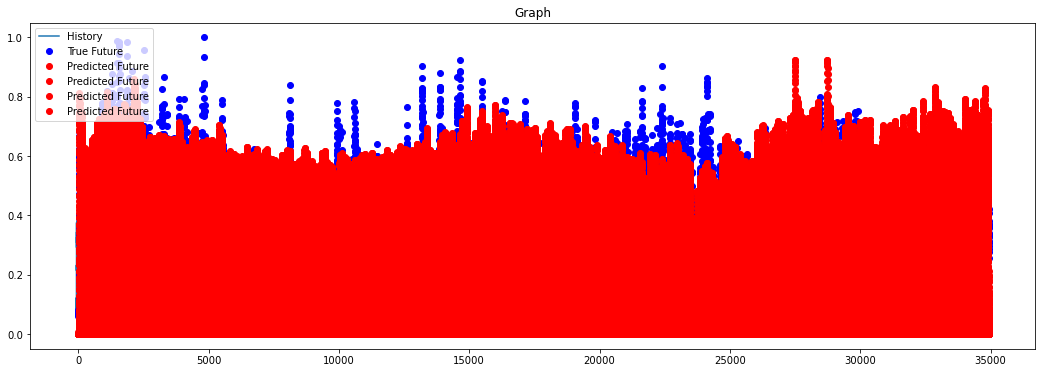

In [11]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])

In [12]:
inputs = Input(shape=(past_history,len(features_considered)))
m = LSTM(64,  return_sequences=True)(inputs)
m = LSTM(128)(m)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=10,steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 8s 63ms/step - loss: 0.0539 - dense_4_loss: 0.0279 - dense_5_loss: 0.0260
Epoch 2/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0450 - dense_4_loss: 0.0242 - dense_5_loss: 0.0209
Epoch 3/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0423 - dense_4_loss: 0.0210 - dense_5_loss: 0.0213
Epoch 4/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0313 - dense_4_loss: 0.0174 - dense_5_loss: 0.0139
Epoch 5/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0309 - dense_4_loss: 0.0167 - dense_5_loss: 0.0142
Epoch 6/10
100/100 [==============================] - 6s 58ms/step - loss: 0.0293 - dense_4_loss: 0.0159 - dense_5_loss: 0.0134
Epoch 7/10
100/100 [==============================] - 6s 58ms/step - loss: 0.0277 - dense_4_loss: 0.0146 - dense_5_loss: 0.0131
Epoch 8/10
100/100 [==============================] - 6s 65ms/step - loss: 0.0266 - dense_4_loss: 0.0135

<ipython-input-13-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.42945796]
 [0.43030964]
 [0.43114795]
 [0.4319689 ]]


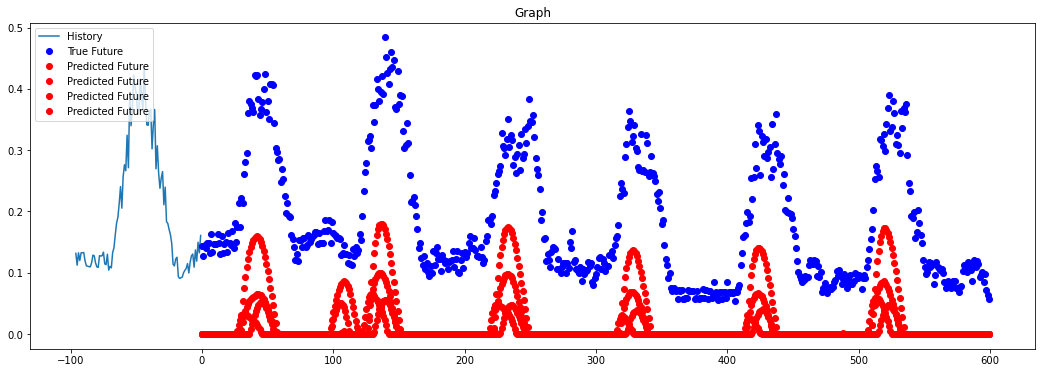

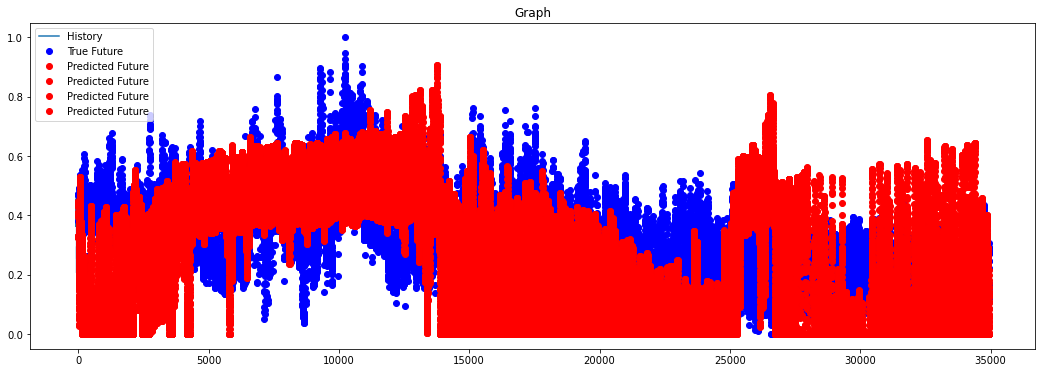

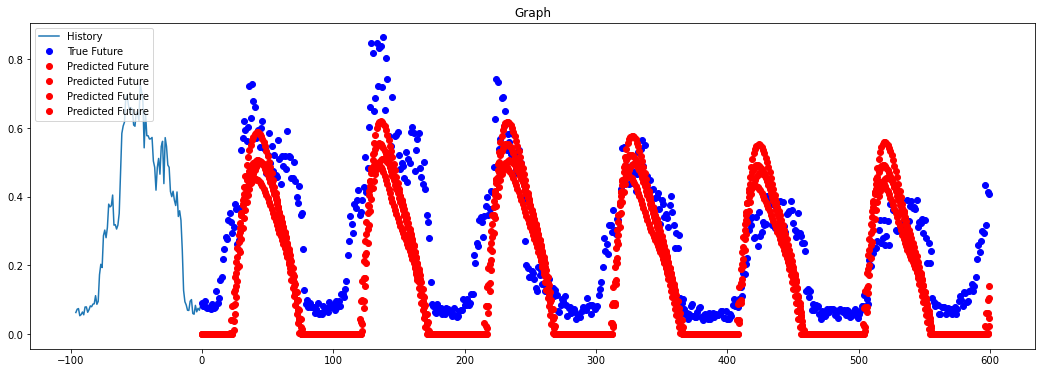

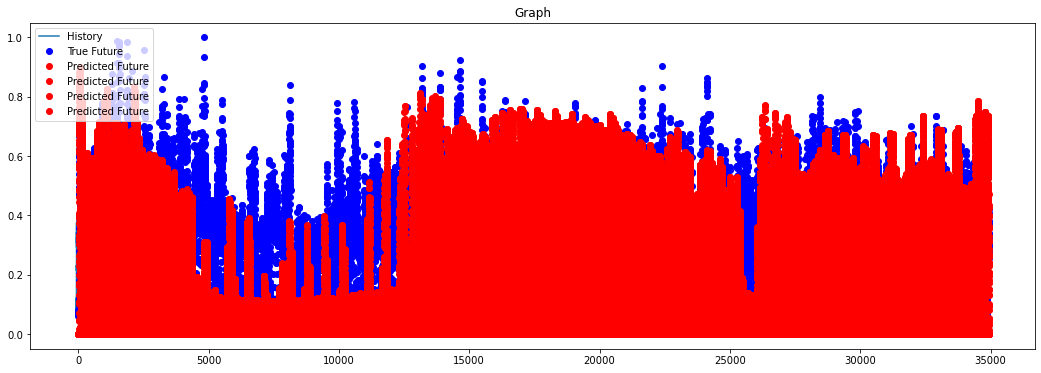

In [13]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])

In [14]:
inputs = Input(shape=(past_history,len(features_considered)))
m = LSTM(64,  return_sequences=True)(inputs)
m = LSTM(128)(m)
m = Dense(96, activation='relu')(m)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=10,steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 8s 65ms/step - loss: 0.0948 - dense_7_loss: 0.0500 - dense_8_loss: 0.0448
Epoch 2/10
100/100 [==============================] - 6s 59ms/step - loss: 0.0838 - dense_7_loss: 0.0453 - dense_8_loss: 0.0384
Epoch 3/10
100/100 [==============================] - 6s 58ms/step - loss: 0.0821 - dense_7_loss: 0.0445 - dense_8_loss: 0.0376
Epoch 4/10
100/100 [==============================] - 6s 58ms/step - loss: 0.0429 - dense_7_loss: 0.0228 - dense_8_loss: 0.0202
Epoch 5/10
100/100 [==============================] - 6s 59ms/step - loss: 0.0287 - dense_7_loss: 0.0142 - dense_8_loss: 0.0145
Epoch 6/10
100/100 [==============================] - 6s 61ms/step - loss: 0.0267 - dense_7_loss: 0.0132 - dense_8_loss: 0.0135
Epoch 7/10
100/100 [==============================] - 6s 60ms/step - loss: 0.0315 - dense_7_loss: 0.0140 - dense_8_loss: 0.0175
Epoch 8/10
100/100 [==============================] - 6s 60ms/step - loss: 0.0242 - dense_7_loss: 0.0114

<ipython-input-15-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.5139609 ]
 [0.51434748]
 [0.51470635]
 [0.51503708]]


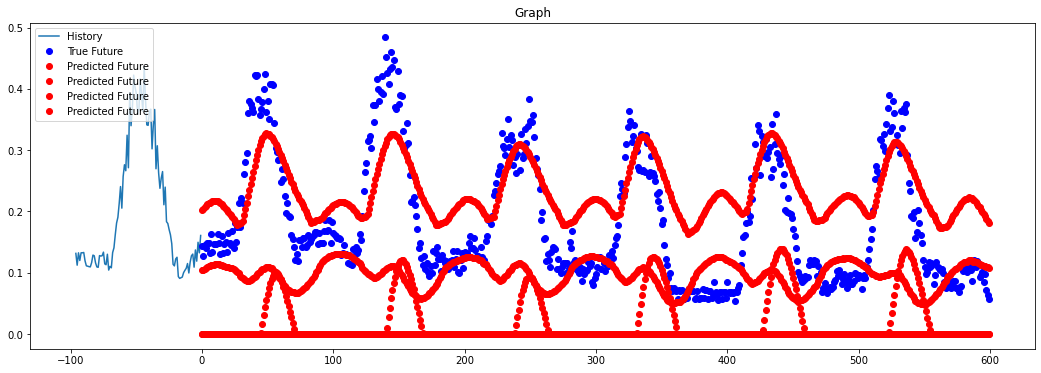

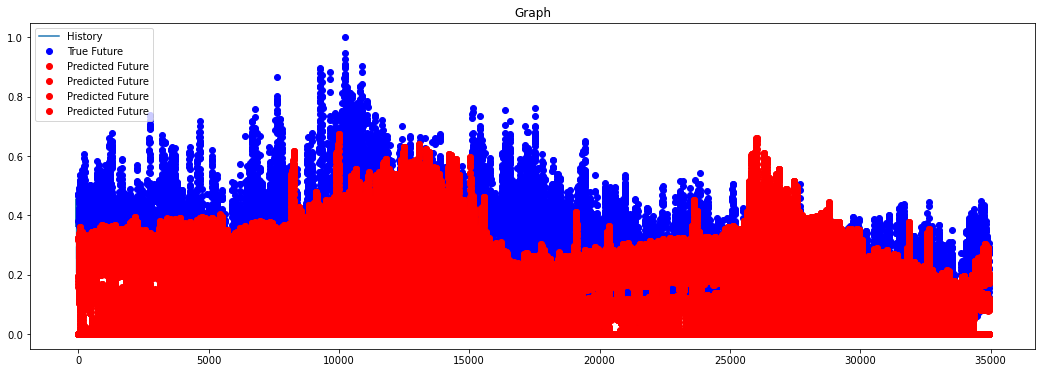

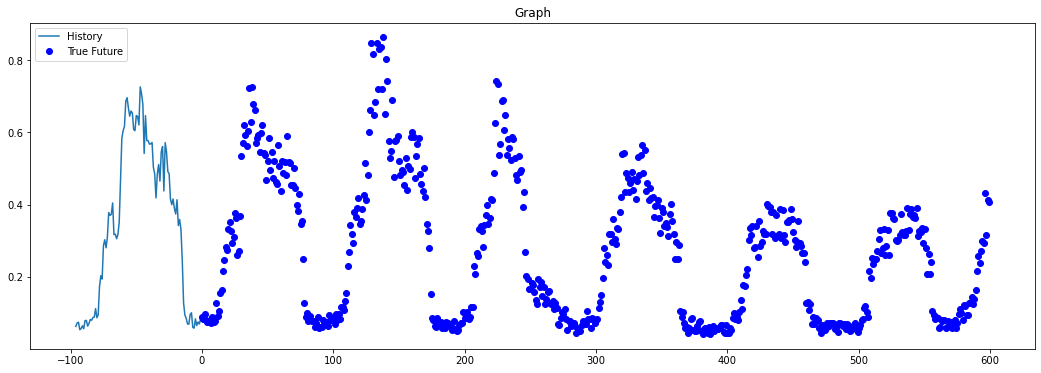

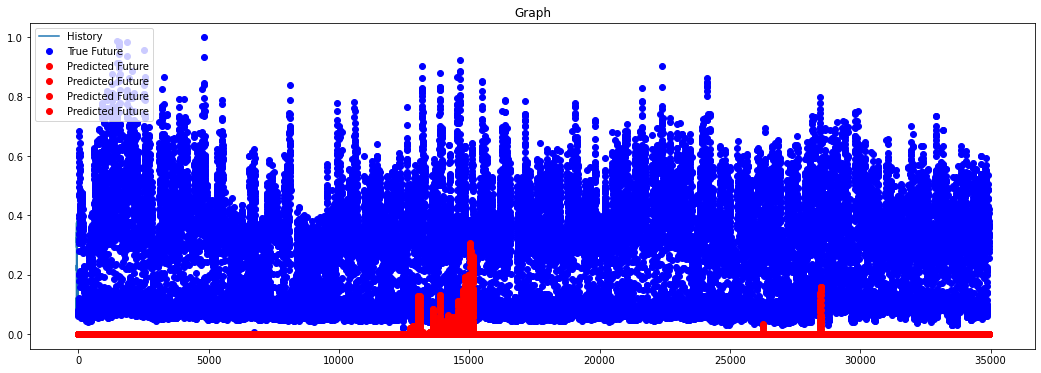

In [15]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])